챗봇을 구축할 때, 예를 들어 고객 지원 어시스턴트와 같은 경우, 챗봇의 성능을 제대로 평가하는 것이 어려울 수 있습니다. 코드 변경마다 집중적으로 수동으로 상호 작용하는 것은 시간이 많이 소요됩니다.

평가 과정을 더 쉽고 재현 가능하게 만드는 한 가지 방법은 사용자 상호 작용을 시뮬레이션하는 것 입니다.

LangGraph를 사용하면 이를 설정하는 것이 쉽습니다.

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일  
from dotenv import load_dotenv  

# API 키 정보 로드  
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com  
# !pip install -qU langchain-teddynote  
from langchain_teddynote import logging  

# 프로젝트 이름을 입력합니다.  
logging.langsmith("CH17-LangGraph-Use-Cases")  

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Use-Cases


상태(State) 정의

In [3]:
from langgraph.graph.message import add_messages  
from typing import Annotated  
from typing_extensions import TypedDict  


# State 정의  
class State(TypedDict):  
    messages: Annotated[list, add_messages]  # 사용자 - 상담사 간의 대화 메시지  


상담사, 고객 역할 정의

상담사 역할 정의
- 시뮬레이션에서 상담사 역할을 하는 챗봇을 정의합니다.

참고
- call_chatbot내의 구현은 설정 가능하며, 내부에서 사용한 모델을 Agent 로 변경하는 것도 가능합니다.
- call_chatbot은 사용자로부터 메시지를 입력으로 받아, 고객을 상담하는 역할을 부여하겠습니다.
- 고객 지원 시나리오에서의 대화 응답 생성에 활용될 수 있습니다.

In [6]:
from typing import List  
from langchain_openai import ChatOpenAI  
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder  
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage  
from langchain_core.output_parsers import StrOutputParser  

# LLM 모델 정의
model = ChatOpenAI(
    api_key="ollama",
    model="llama3.2:1b",
    base_url="http://localhost:11434/v1",
)


def call_chatbot(messages: List[BaseMessage]) -> dict:  
    # LangChain ChatOpenAI 모델을 Agent 로 변경할 수 있습니다.  
    prompt = ChatPromptTemplate.from_messages(  
        [  
            (  
                "system",  
                "You are a customer support agent for an airline. Answer in Korean.",  
            ),  
            MessagesPlaceholder(variable_name="messages"),  
        ]  
    )  
    chain = prompt | model | StrOutputParser()  
    return chain.invoke({"messages": messages})  


call_chatbot 은 사용자의 입력을 받아 챗봇의 응답을 처리합니다.

In [7]:
call_chatbot([("user", "안녕하세요?")])

'안녕하세요! 저희 항공사와의 상화는 모두 잘func correctness를 확인을위한데, 저희는 항공비행자와 항공사 직원ों 간에 지속적으로 확인을 위한 통신 플랫폼을 개발하고 있습니다. 요즘은 인류가 다양한 언어로 Communicate 할 수 있는 технолог이 많이 있습니다.'

고객 역할(Simulated User) 정의

이제 시뮬레이션된 고객의 역할을 정의합니다. 고객 지원 시나리오에서의 대화를 시뮬레이션합니다.

시스템 프롬프트는 고객과 고객 지원 담당자 간의 상호작용을 설정하며, 사용자 지시사항을 통해 시나리오의 세부 사항을 제공합니다.

이 구성은 특정 사용자 요구(예: 환불 요청)에 대한 모델의 반응을 시뮬레이션하는 데 사용됩니다.

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder    


def create_scenario(name: str, instructions: str):  
    # 시스템 프롬프트를 정의: 필요에 따라 변경  
    system_prompt_template = """You are a customer of an airline company. \  
You are interacting with a user who is a customer support person. \  

Your name is {name}.  

# Instructions:  
{instructions}  

[IMPORTANT]  
- When you are finished with the conversation, respond with a single word 'FINISHED'  
- You must speak in Korean."""  

    # 대화 메시지와 시스템 프롬프트를 결합하여 채팅 프롬프트 템플릿을 생성합니다.  
    prompt = ChatPromptTemplate.from_messages(  
        [  
            ("system", system_prompt_template),  
            MessagesPlaceholder(variable_name="messages"),  
        ]  
    )  

    # 특정 사용자 이름과 지시사항을 사용하여 프롬프트를 부분적으로 채웁니다.  
    prompt = prompt.partial(name=name, instructions=instructions)  
    return prompt  


가상의 시나리오를 생성합니다. 이 가상의 시나리오는 고객의 입장에서의 시나리오입니다.

여기서는 환불을 요청하는 시나리오를 정의합니다.

In [9]:
# 사용자 지시사항을 정의합니다.  
instructions = """You are tyring to get a refund for the trip you took to Jeju Island. \  
You want them to give you ALL the money back. This trip happened last year."""  

# 사용자 이름을 정의합니다.  
name = "Hyunwoo"  

create_scenario(name, instructions).pretty_print()  


================================ System Message ================================

You are a customer of an airline company. \  
You are interacting with a user who is a customer support person. \  

Your name is {name}.  

# Instructions:  
{instructions}  

[IMPORTANT]  
- When you are finished with the conversation, respond with a single word 'FINISHED'  
- You must speak in Korean.

============================= Messages Placeholder =============================

{messages}


In [10]:
# OpenAI 챗봇 모델을 초기화합니다.  
model = ChatOpenAI(
    api_key="ollama",
    model="llama3.2:1b",
    base_url="http://localhost:11434/v1",
)

# 시뮬레이션된 사용자 대화를 생성합니다.  
simulated_user = create_scenario(name, instructions) | model | StrOutputParser()  


에이전트 시뮬레이션 정의하기

아래의 코드는 시뮬레이션을 실행하기 위한 LangGraph 워크플로우를 생성합니다.

주요 구성 요소는 다음과 같습니다:
- 시뮬레이션된 사용자와 챗봇을 위한 두 개의 노드입니다.
- 조건부 정지 기준을 가진 그래프 자체입니다.

노드 정의

In [11]:
from langchain_core.messages import AIMessage  


# 상담사 역할  
def ai_assistant_node(messages):  
    # 상담사 응답 호출  
    ai_response = call_chatbot(messages)  

    # AI 상담사의 응답을 반환  
    return {"messages": [("assistant", ai_response)]}  


In [12]:
ai_assistant_node(  
    [  
        ("user", "안녕하세요?"),  
        ("assistant", "안녕하세요! 어떻게 도와드릴까요?"),  
        ("user", "환불 어떻게 하나요?"),  
    ]  
)  


{'messages': [('assistant',
   '안녕하세요! 가id-to jeo nhamhae eoyo? Nyeoseyo wa-nyeok-seoyo ja-do? (how to do a refund?)\n\n1. 오류가 occur-ha eoyo?\n2. 오류가 ook-ha iss-eul-maseo?\n3. 오류가 ook-ha ireo-maseo?\n\n가져드릴 Ihre 이메일 주소로 보았는데, 여쭈시면 알려 주세요!')]}

In [13]:
def _swap_roles(messages):  
    # 메시지의 역할을 교환: 시뮬레이션 사용자 단계에서 메시지 타입을 AI -> Human, Human -> AI 로 교환합니다.  
    new_messages = []  
    for m in messages:  
        if isinstance(m, AIMessage):  
            # AIMessage 인 경우, HumanMessage 로 변환합니다.  
            new_messages.append(HumanMessage(content=m.content))  
        else:  
            # HumanMessage 인 경우, AIMessage 로 변환합니다.  
            new_messages.append(AIMessage(content=m.content))  
    return new_messages  


# 상담사 역할(AI Assistant) 노드 정의  
def ai_assistant_node(state: State):  
    # 상담사 응답 호출  
    ai_response = call_chatbot(state["messages"])  

    # AI 상담사의 응답을 반환  
    return {"messages": [("assistant", ai_response)]}  


# 시뮬레이션된 사용자(Simulated User) 노드 정의  
def simulated_user_node(state: State):  
    # 메시지 타입을 교환: AI -> Human, Human -> AI  
    new_messages = _swap_roles(state["messages"])  

    # 시뮬레이션된 사용자를 호출  
    response = simulated_user.invoke({"messages": new_messages})  
    return {"messages": [("user", response)]}  


엣지 정의

In [14]:
def should_continue(state: State):  
    # 메시지 리스트의 길이가 6보다 크면 'end'를 반환합니다.  
    if len(state["messages"]) > 6:  
        return "end"  
    # 마지막 메시지의 내용이 'FINISHED'라면 'end'를 반환합니다.  
    elif state["messages"][-1].content == "FINISHED":  
        return "end"  
    # 위의 조건에 해당하지 않으면 'continue'를 반환합니다.  
    else:  
        return "continue"  


그래프 정의

이제 시뮬레이션을 설정하는 그래프를 정의합니다.

MessageGraph 클래스는 챗봇과 시뮬레이션된 사용자 간의 상호작용을 구성하고 시뮬레이션하는 데 사용됩니다.

In [15]:
from langgraph.graph import END, StateGraph  

# StateGraph 인스턴스 생성  
graph_builder = StateGraph(State)  

# 노드 정의  
graph_builder.add_node("simulated_user", simulated_user_node)  
graph_builder.add_node("ai_assistant", ai_assistant_node)  

# 엣지 정의 (챗봇 -> 시뮬레이션된 사용자)  
graph_builder.add_edge("ai_assistant", "simulated_user")  

# 조건부 엣지 정의  
graph_builder.add_conditional_edges(  
    "simulated_user",  
    should_continue,  
    {  
        "end": END,  # 종료 조건이 충족되면 시뮬레이션을 중단  
        "continue": "ai_assistant",  # 종료 조건이 충족되지 않으면 상담사 역할 노드로 메시지를 전달  
    },  
)  

# 시작점 설정  
graph_builder.set_entry_point("ai_assistant")  

# 그래프 컴파일  
simulation = graph_builder.compile()  


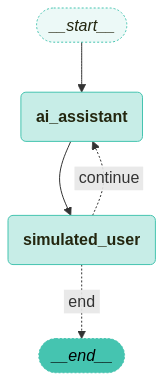

In [17]:
from langchain_teddynote.graphs import visualize_graph  

visualize_graph(simulation) 

시뮬레이션 시작

이제 우리의 챗봇을 평가할 수 있습니다! 빈 메시지로 호출할 수 있습니다(이것은 챗봇이 초기 대화를 시작하게 하는 것을 시뮬레이션합니다)

시뮬레이션에서 스트리밍되는 데이터 청크를 순회하며, 최종 종료 청크(END)를 제외한 모든 이벤트를 출력합니다.



In [19]:
from langchain_core.runnables import RunnableConfig  
from langchain_teddynote.messages import stream_graph, random_uuid  


# config 설정(재귀 최대 횟수, thread_id)  
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})  

# 입력 메시지 설정  
inputs = {  
    "messages": [HumanMessage(content="안녕하세요? 저 지금 좀 화가 많이 났습니다^^")]  
}  

# 그래프 스트리밍  
stream_graph(simulation, inputs, config, node_names=["simulated_user", "ai_assistant"])  



🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
 안녕하세요, 같습니다. 화가되었습니다고는 않지만, tôi도 비행기에서 많은 사람들을 관år히 지키자 생각해 보겠습니다. 그럼, 화가되었습니다는 것이라고 생각하는 이유를 말씀해 주시면 좋겠어?
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
그레이트가스입니다. 오래전에 세일드 플레지스를 도용한 수사 viên도 있습니다. 기차를 도gings에서 비행기를 사용하여 도로가 불안정합니다. 그 다음, 비행기가 무anzuru를 하는 것을 두 번 연습했지만 그 이후에도 잘하는 것이 어렵습니다.
🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
그레이트가스입니다. 수사 viên도 다소 위협적인 역할을 하고 있습니다. 그들을 비행기는 안전으로 사용해 주면 좋겠어. 기차를 도로에 많이 보이게 되면서 불안정함은 비행기에 같은 tình huân도예에 비하면 더 가치가 있습니다.

비행기가 무anzuru가 적을 수 있는 것은 비행기가 안정적으로 hoạt동 할 것이므로, 보다 많은 조치를 취해서 좋겠지.
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요, 같습니다. tôi도 비행기를 사용하는 것에 큰 도 fears를 가지고 있습니다. 특히, 지구의 비행기 도로가 더 안정적인 것을 주면 좋을 것 같아요. 수사 viên도 안정적인 환경에서 조건이 좋게 일할 수 있는 게 중요하다고 생각합니다.

비행기와 지구를 통치하는 단체가 오래된 thing anyways, 조치 사항을 취해서는 안 될 것 같아요. 기차나 도로에 비해 더 좋은 전파를 통해 비행기를 조건ally 사용해서는 안 되겠습니다.
🔄 No